# Quantitative Bias Analysis: Monte Carlo Risk Ratio 
This tutorial goes over quantatitative bias analysis using the Monte-Carlo analysis. This approach is also referred to as probabilistic bias analysis. This sensitivity analysis is useful when you believe there is another confounder in your data set, but it was unmeasured in your data set. The Monte-Carlo procedure allows you to bring in outside information to correct for your estimated risk ratio. Currently, only risk ratios are supported in *zEpid* for this procedure

To frame the following example, we will use the example in Chapter 9 of *Modern Epidemiology* 3rd Edition. Imagine you are studying the association between occupational resin and lung cancer. In our study, the estimate risk ratio was 2.43 ($RR = 2.43$), but our data did not have information on smoking. Based on substantive knowledge, we believe that smoking is confounding our association. 

To inform our bias analysis, we did some searching and found parameters of what we believe to be reasonable values for; the proportion of smokers in the occupational resin exposed group, the proportion of smokers in the occupational resin non-exposed group, and the risk ratio between smoking and lung cancer. There are some uncertainties around these values, so we need to discern reasonable distributions. Commonly used distributions are; logitistic, normal, uniform, and trapezoidal

## Trapezoidal Distributions
Before continuing, I wanted to highlight trapezoidal distributions. These are not available in `numpy`, so I create my own implementation of these distributions. Before continuing, I wanted to highlight these, since we will be using them later.

Within the `sensitivity_analysis` branch, `trapezoidal` is avaiable to generate trapezoidal distrubtions. This distribution has 4 parameters; the minimum (`mini`), the lower mode (`mode1`), the upper mode (`mode2`), and the maximum (`maxi`). Between the minimum and lower mode, and upper mode and maximum are triangle distributions. Between the lower and upper mode are a uniform distribution. I believe it is easier to visualize, so let's look at an example

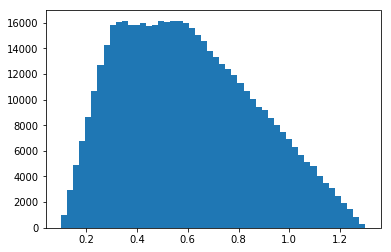

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from zepid.sensitivity_analysis import trapezoidal

trpzd = trapezoidal(mini=0.1, mode1=0.3, mode2=0.6, maxi=1.3, size=500000)
plt.hist(trpzd, bins=50)
plt.show()

As displayed in the distribution above, there is a uniform distribution between 0.3 to 0.6 flanked by two triangle distributions. Note that the triangles are not restricted to be uniform either. Trapezoidal distributions are generally preferred over uniform distributions for Monte-Carlo sensitivity analyses, since they can better reflect our uncertainty.

## Monte-Carlo Sensitivity Analysis
Now that we introduced trapezoidal distributions, let's return to our probabilistic bias analysis problem. To conduct our bias analysis, we will use `MonteCarloRR`. Before we can begin our sensitivity analysis, we have three parameters that need distributions specified; proportion of smokers in the occupational resin exposed group ($p1$), proportion of smokers in the occupational resin non-exposed group ($p0$), and the risk ratio between smoking and lung cancer ($RR_c$). For demonstration, we will use the following distributions

$$p1 \sim uniform(0.6, 0.8)$$

$$p0 \sim trapezoidal(0.4, 0.5, 0.6, 0.75)$$

$$RR_c \sim trapezoidal(2.2, 3.1, 5.2, 7.1)$$

While I generally would recommend trapezoidal distributions over uniform, I am using a uniform distribution for $p1$ for illustrative purposes. Specifically, I want to show that `MonteCarloRR` supports `numpy` distributions.

### Bias Analysis without Random Error
First, we will go through a bias analysis that does not incorporate random error. This analysis reflects only the bias in the point estimate. To conduct this analysis, we provide `MonteCarloRR` with our observed point estimate and the three above distributions for the corresponding parameters. Let's demonstrate

In [2]:
import numpy as np
from zepid.sensitivity_analysis import MonteCarloRR

# Initializing MonteCarloRR with observed risk ratio
mcrr = MonteCarloRR(observed_RR=2.43)

# Specifying p1 distribution
mcrr.prop_confounder_exposed(dist=np.random.uniform(0.6, 0.8, size=mcrr.sample))

# Specifying p0 distribution
mcrr.prop_confounder_unexposed(dist=trapezoidal(0.4, 0.5, 0.6, 0.75, size=mcrr.sample))

# Specifying risk ratio for unobserved confounder and outcome
mcrr.confounder_RR_distribution(dist=trapezoidal(2.2, 3.1, 5.2, 7.1, size=mcrr.sample))

# Estimating corrected risk ratios
mcrr.fit()

# Generating summary data
mcrr.summary()

----------------------------------------------------------------------
Median corrected Risk Ratio:  2.102
Mean corrected Risk Ratio:  2.111
25th & 75th Percentiles:  [1.953 2.263]
2.5th & 97.5th Percentiles:  [1.703 2.561]
----------------------------------------------------------------------


As we can see, our risk ratio moves towards the null ($RR=1$) value when comparing the observed and the median corrected risk ratio ($RR_{obs} = 2.43 > 2.11 = RR^*$). However, the various distributions still suggest that occupational resin exposure is associated with lung cancer despite the unobserved smoking (assuming our distributions are correct and that smoking is independent of other variables). 

#### Plots
Potentially more helpful for understanding the results are plots. These can be generated by

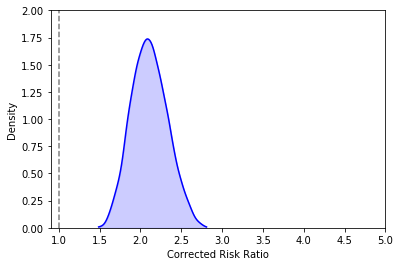

In [3]:
mcrr.plot()
plt.vlines(1.0, 0, 2, linestyle='--', color='gray')
plt.xlim([0.9, 5])
plt.ylim([0, 2])
plt.show()

As seen in our plot, our point estimate remains elevated even when we account for the unobserved confounder of smoking. However, this distribution only reflects the point estimate, i.e. it does not incorporate the random error of our estimate.

### Bias Analysis with Random Error
Random error support was added to *zEpid* beginning in v0.5.0. To incorporate random error into our bias analysis, we can specify the `sd` parameter, which is the standard deviation of the observed log risk ratio. To incorporate random error into the bias analysis, random error from a normal distribution based on the standard deviation is added/subtracted to each corrected log(risk ratio). 

Depending on the extent of random error, the above distribution may become sparse. To increase the Monte-Carlo procedure, the optional `sample` parameter can be specified. The default is 10,000. For this example, we will increase it to 100,000. 

From our above study, the standard deviation of the observed log risk ratio was 0.15 ($SD(\log(RR)) = 0.15$).

----------------------------------------------------------------------
Median corrected Risk Ratio:  2.104
Mean corrected Risk Ratio:  2.137
25th & 75th Percentiles:  [1.856 2.381]
2.5th & 97.5th Percentiles:  [1.463 2.994]
----------------------------------------------------------------------


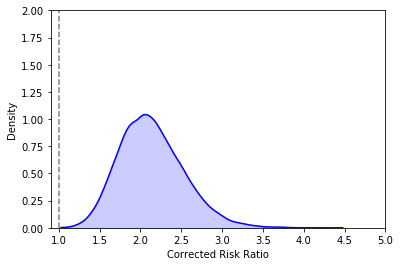

In [4]:
# Initializing MonteCarloRR with observed risk ratio
mcrr = MonteCarloRR(observed_RR=2.43, sd=0.15, sample=50000)

# Applying distributions
mcrr.prop_confounder_exposed(dist=np.random.uniform(0.6, 0.8, size=mcrr.sample))
mcrr.prop_confounder_unexposed(dist=trapezoidal(0.4, 0.5, 0.6, 0.75, size=mcrr.sample))
mcrr.confounder_RR_distribution(dist=trapezoidal(2.2, 3.1, 5.2, 7.1, size=mcrr.sample))
mcrr.fit()

# Generating summary data
mcrr.summary()

# Generating plot
mcrr.plot()
plt.vlines(1.0, 0, 2, linestyle='--', color='gray')
plt.xlim([0.9, 5])
plt.ylim([0, 2])
plt.show()

In this example, we can see that random error widens our percentiles. However, by incorporating random error, we can interpret the 2.5th and 97.5th percentiles at the 95% confidence limits of the bias-corrected risk ratio (${RR}^* = 2.11, 95\% CL: 1.47, 3.00$). This conclusion is much stronger than the previous bias analysis, where we could only discuss the variability of the point estimate itself.

Depending on the extent of random error in your study, the difference between Monte-Carlo analysis with and without random error can change. Specifically, the less random error, the less of a difference between the two variations of Monte-Carlo analysis.

# Conclusion
In this tutorial, we went over a brief example of quantitative (probabilistic) bias analysis for the risk ratio and additional introduced the trapezoidal distribution. For this approach to be useful we need to have good information on three distributions, and assume the confounder is independent of all other variables included in our analysis aside from the exposure and outcome.

Probabilistic bias analysis can be paired with other systematic error corrections, such as for selection and measurment error. These are not currently supported by `MonteCarloRR`. There is a major caveat for this approach. That being, the order of the bias analysis procedure must be in reverse order of their occurrence. Furthermore, the various systematic errors must be assumed to be independent of each other for this approach